### Libraries

In the following cell are the libraries used for the project. 


In [2]:
# load packages
if (!require("BiocManager", quietly = TRUE))    install.packages("BiocManager")
if (!require("Rgraphviz", quietly = TRUE))      BiocManager::install(c("graph", "Rgraphviz"))
if (!require("igraph", quietly = TRUE))         install.packages("igraph")
if (!require("tidyverse", quietly = TRUE))      install.packages("tidyverse")
if (!require("bnlearn", quietly = TRUE))        install.packages("bnlearn")
if (!require("DescTools", quietly = TRUE))      install.packages("DescTools")
if (!require("dplyr", quietly = TRUE))          install.packages("dplyr")
if (!require("infotheo", quietly = TRUE))       install.packages("infotheo")


library(infotheo)  |> suppressPackageStartupMessages()
library(tidyverse) |> suppressPackageStartupMessages()
library(bnlearn)   |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()
library(DescTools) |> suppressPackageStartupMessages()
library(igraph)    |> suppressPackageStartupMessages()
library(dplyr)     |> suppressPackageStartupMessages()

### The K2 algorthm 


In [3]:
k2 <- function(u, dataset, ordering = names(dataset)) {
    nodes <- ordering
    net.dag <- empty.graph(nodes = nodes)
    parent.list <- vector("list", length(nodes))
    names(parent.list) <- nodes
    score.log <- list()  # NEW: to store scores

    for (i in seq_along(nodes)) {
        node <- nodes[i]
        if (i == 1) {
            prev.nodes <- character(0)
        } else {
            prev.nodes <- nodes[1:(i-1)]
        }
        parents <- character(0)
        P_old <- f(node, parents, dataset)
        OK <- TRUE
        score.log[[node]] <- list()  # NEW: store for this node
        while (OK && length(parents) < u && length(prev.nodes) > 0) {
            scores <- sapply(prev.nodes, function(p) f(node, c(parents, p), dataset))
            # NEW: store scores for this step
            score.log[[node]][[paste(sort(c(parents)), collapse = ",")]] <- 
                setNames(as.list(scores), prev.nodes)
            z <- prev.nodes[which.max(scores)]
            P_new <- max(scores)
            if (P_new > P_old && z != node) {
                P_old <- P_new
                parents <- c(parents, z)
                prev.nodes <- setdiff(prev.nodes, z)
                net.dag <- set.arc(net.dag, z, node)
            } else {
                OK <- FALSE
            }
        }
        parent.list[[node]] <- parents
    }
    return(list(dag = net.dag, parents = parent.list, scores = score.log))  # NEW: return scores
}

### The score function f

In [4]:
f <- function(node, parents, dataset) {

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq >= 0)

    numerator <- contingency_table |>
                    mutate(Freq = factorial(Freq)) |>
                    group_by_at(parents) |>
                    summarise(Freq = prod(Freq), .groups='drop_last') |>
                    mutate(Freq = (Freq * factorial(node.nunique - 1))) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    denominator <- contingency_table |>
                    group_by_at(parents) |>
                    summarise(Freq = sum(Freq), .groups='drop_last') |>
                    mutate(Freq = factorial(Freq + node.nunique - 1)) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    dataset.prob <- prod(numerator / denominator)

    return(dataset.prob)

}

### Score function in scale log 

In [5]:
f <- function(node, parents, dataset) { #log one 

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq > 0)

    A <- 1:(node.nunique - 1) |>
            log() |>
            sum()

    B <- contingency_table |>
            rowwise() |>
            mutate(Freq = ((1:Freq) |> log() |> sum())) |>
            ungroup() |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            select(Freq) |>
            deframe()

    C <- contingency_table |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            rowwise() |>
            mutate(Freq = ((1:(Freq + node.nunique - 1)) |> log() |> sum())) |>
            ungroup() |>
            select(Freq) |>
            deframe()

    dataset.log.prob <- sum(A + B - C)
    
    return(dataset.log.prob)

}

### The Mutual Information Ordering Algorithm 


In [6]:
# Main function to get node ordering for K2 algorithm
get_node_ordering_for_K2 <- function(data, alpha = 0.9, max_parents = NULL) {
  
  # Convert data to discrete numeric format
  data_discrete <- prepare_discrete_data(data)
  
  # PHASE 1: Build Undirected Network
  cat("PHASE 1: Building Undirected Network...\n")
  undirected_network <- build_undirected_network(data_discrete, alpha)
  
  # PHASE 2: Achieve Complete Connectivity
  cat("PHASE 2: Achieving Complete Connectivity...\n")
  complete_network <- achieve_complete_connectivity(undirected_network$adj_matrix, 
                                                   undirected_network$mi_matrix)
  
  # PHASE 3: Refine Graph Structure
  cat("PHASE 3: Refining Graph Structure...\n")
  refined_network <- refine_graph_structure(complete_network, data_discrete, 
                                          undirected_network$mi_matrix)
  
  # PHASE 4-7: Assign Orientations
  cat("PHASE 4-7: Assigning Orientations...\n")
  directed_network <- assign_orientations(refined_network, data_discrete)
  
  # Extract topological order
  node_order <- extract_topological_order(directed_network)
  
  return(node_order)
}

# Function to prepare discrete data
prepare_discrete_data <- function(data) {
  data_discrete <- data
  
  for (col in names(data)) {
    # If column is character or logical, convert to factor
    if (is.character(data[[col]]) || is.logical(data[[col]])) {
      data_discrete[[col]] <- as.factor(data[[col]])
    }
    # If numeric with few unique values, consider already discrete
    else if (is.numeric(data[[col]]) && length(unique(data[[col]])) < 20) {
      data_discrete[[col]] <- as.factor(data[[col]])
    }
    # Otherwise discretize using equal-width binning
    else {
      data_discrete[[col]] <- cut(data[[col]], breaks = 5, labels = FALSE)
    }
  }
  
  # Convert everything to numeric for MI calculation
  data_numeric <- as.data.frame(lapply(data_discrete, as.numeric))
  names(data_numeric) <- names(data)
  
  return(data_numeric)
}

# PHASE 1: Build Undirected Network
build_undirected_network <- function(data, alpha) {
  n_vars <- ncol(data)
  var_names <- names(data)
  
  # Calculate Mutual Information for all variable pairs
  mi_matrix <- matrix(0, n_vars, n_vars, dimnames = list(var_names, var_names))
  
  cat("Calculating Mutual Information...\n")
  for (i in 1:(n_vars-1)) {
    for (j in (i+1):n_vars) {
      # Calculate MI using infotheo library
      mi_value <- mutinformation(data[,i], data[,j])
      mi_matrix[i,j] <- mi_value
      mi_matrix[j,i] <- mi_value  # MI is symmetric
    }
  }
  
  # Find Maximum MI (MMI) for each node
  mmi <- apply(mi_matrix, 1, function(x) max(x[x > 0], na.rm = TRUE))
  
  # Build initial adjacency matrix
  adj_matrix <- matrix(0, n_vars, n_vars, dimnames = list(var_names, var_names))
  
  # Add edges according to the condition in the paper
  cat("Building initial network...\n")
  for (i in 1:n_vars) {
    for (j in 1:n_vars) {
      if (i != j) {
        # Condition: I(X,Y) >= α * MMI(X) OR I(Y,X) >= α * MMI(Y)
        if (mi_matrix[i,j] >= alpha * mmi[i] || mi_matrix[j,i] >= alpha * mmi[j]) {
          adj_matrix[i,j] <- 1
          adj_matrix[j,i] <- 1
        }
      }
    }
  }
  
  return(list(adj_matrix = adj_matrix, mi_matrix = mi_matrix))
}

# PHASE 2: Achieve Complete Connectivity
achieve_complete_connectivity <- function(adj_matrix, mi_matrix) {
  n_vars <- nrow(adj_matrix)
  var_names <- rownames(adj_matrix)
  
  # Create ordered list of node pairs by decreasing MI
  mi_pairs <- list()
  k <- 1
  for (i in 1:(n_vars-1)) {
    for (j in (i+1):n_vars) {
      mi_pairs[[k]] <- list(i = i, j = j, mi = mi_matrix[i,j])
      k <- k + 1
    }
  }
  mi_pairs <- mi_pairs[order(sapply(mi_pairs, function(x) x$mi), decreasing = TRUE)]
  
  # Check complete connectivity
  cat("Achieving complete connectivity...\n")
  while (!is_completely_connected(adj_matrix)) {
    # Add edges according to paper rules
    for (pair in mi_pairs) {
      i <- pair$i
      j <- pair$j
      
      if (adj_matrix[i,j] == 0) {  # If edge doesn't exist yet
        # Check conditions to add edge
        # 1. Target node is not connected to any other node
        # 2. Source node is not connected to any other node  
        # 3. There's no path between source and target
        
        if (sum(adj_matrix[i,]) == 0 || sum(adj_matrix[j,]) == 0 ||
            !has_path(adj_matrix, i, j)) {
          adj_matrix[i,j] <- 1
          adj_matrix[j,i] <- 1
          
          # If now completely connected, exit
          if (is_completely_connected(adj_matrix)) {
            break
          }
        }
      }
    }
  }
  
  return(adj_matrix)
}

# Function to check if graph is completely connected
is_completely_connected <- function(adj_matrix) {
  if (nrow(adj_matrix) == 1) return(TRUE)
  g <- graph_from_adjacency_matrix(adj_matrix, mode = "undirected")
  return(is_connected(g))
}

# Function to check if path exists between two nodes
has_path <- function(adj_matrix, from, to) {
  if (from == to) return(TRUE)
  
  # Temporarily remove direct edge between nodes
  temp_adj <- adj_matrix
  temp_adj[from, to] <- 0
  temp_adj[to, from] <- 0
  
  g <- graph_from_adjacency_matrix(temp_adj, mode = "undirected")
  
  # If one node is isolated after removal, there's no path
  if (degree(g)[from] == 0 || degree(g)[to] == 0) {
    return(FALSE)
  }
  
  paths <- shortest_paths(g, from = from, to = to)
  return(length(paths$vpath[[1]]) > 0)
}

# PHASE 3: Refine Graph Structure
refine_graph_structure <- function(adj_matrix, data, mi_matrix) {
  n_vars <- nrow(adj_matrix)
  var_names <- rownames(adj_matrix)
  
  # Find all triangles in the graph
  triangles <- find_triangles(adj_matrix)
  
  cat(sprintf("Found %d triangles to refine...\n", length(triangles)))
  
  for (triangle in triangles) {
    # triangle contains indices of three nodes
    nodes <- triangle
    
    # Test conditional independence for each edge of the triangle
    edge_removed <- FALSE
    
    # Test for edge A-B conditioned on C
    if (test_conditional_independence(data, nodes[1], nodes[2], nodes[3])) {
      adj_matrix[nodes[1], nodes[2]] <- 0
      adj_matrix[nodes[2], nodes[1]] <- 0
      edge_removed <- TRUE
    }
    # Test for edge A-C conditioned on B
    else if (test_conditional_independence(data, nodes[1], nodes[3], nodes[2])) {
      adj_matrix[nodes[1], nodes[3]] <- 0
      adj_matrix[nodes[3], nodes[1]] <- 0
      edge_removed <- TRUE
    }
    # Test for edge B-C conditioned on A
    else if (test_conditional_independence(data, nodes[2], nodes[3], nodes[1])) {
      adj_matrix[nodes[2], nodes[3]] <- 0
      adj_matrix[nodes[3], nodes[2]] <- 0
      edge_removed <- TRUE
    }
    
    # If no test succeeds, try with potential parents (simplified)
    if (!edge_removed) {
      # For now keep the triangle
      # A complete implementation would search for common parents using MI
    }
  }
  
  return(adj_matrix)
}

# Function to find all triangles in the graph
find_triangles <- function(adj_matrix) {
  g <- graph_from_adjacency_matrix(adj_matrix, mode = "undirected")
  cliques <- cliques(g, min = 3, max = 3)
  return(lapply(cliques, as.numeric))
}

# Conditional independence test
test_conditional_independence <- function(data, x_idx, y_idx, z_idx) {
  # Get column names from indices
  var_names <- names(data)
  x_name <- var_names[x_idx]
  y_name <- var_names[y_idx]
  z_name <- var_names[z_idx]
  
  # For discrete data, use G2 or chi-square test
  # Here we use simplified implementation based on conditional MI
  
  # Calculate MI(X,Y|Z)
  # If MI(X,Y|Z) ≈ 0, then X and Y are conditionally independent given Z
  
  # Alternative implementation without bnlearn
  # Use formula: MI(X,Y|Z) = MI(X,Y,Z) - MI(X,Z) - MI(Y,Z) + MI(Z)
  
  # For simplicity, use threshold
  threshold <- 0.01
  
  # Calculate conditional mutual information
  xyz_data <- data[, c(x_idx, y_idx, z_idx)]
  
  # MI(X,Y|Z) using entropy
  mi_xy <- mutinformation(data[,x_idx], data[,y_idx])
  mi_xz <- mutinformation(data[,x_idx], data[,z_idx])
  mi_yz <- mutinformation(data[,y_idx], data[,z_idx])
  
  # Approximation: if MI(X,Y) << MI(X,Z) and MI(Y,Z), probably independent given Z
  cond_mi_approx <- mi_xy - min(mi_xz, mi_yz)
  
  return(cond_mi_approx < threshold)
}

# PHASE 4-7: Assign Orientations
assign_orientations <- function(adj_matrix, data) {
  n_vars <- nrow(adj_matrix)
  
  # Create matrix for directed graph
  dag_matrix <- matrix(0, n_vars, n_vars, dimnames = list(rownames(adj_matrix), 
                                                          colnames(adj_matrix)))
  
  # PHASE 4: Conditional independence tests to assign some orientations
  dag_matrix <- phase4_conditional_independence(adj_matrix, dag_matrix, data)
  
  # PHASE 5-7: For simplicity, orient remaining edges avoiding cycles
  dag_matrix <- complete_orientation(adj_matrix, dag_matrix)
  
  return(dag_matrix)
}

# PHASE 4: Conditional independence tests
phase4_conditional_independence <- function(adj_matrix, dag_matrix, data) {
  n_vars <- nrow(adj_matrix)
  
  cat("PHASE 4: Conditional independence tests...\n")
  
  for (c in 1:n_vars) {
    neighbors <- which(adj_matrix[c,] == 1)
    
    if (length(neighbors) >= 2) {
      for (i in 1:(length(neighbors)-1)) {
        for (j in (i+1):length(neighbors)) {
          a <- neighbors[i]
          b <- neighbors[j]
          
          # If A and B are not directly connected
          if (adj_matrix[a,b] == 0) {
            # If A and B are not conditionally independent given C
            if (!test_conditional_independence(data, a, b, c)) {
              # Orient A -> C and B -> C (v-structure)
              dag_matrix[a,c] <- 1
              dag_matrix[b,c] <- 1
            }
          }
        }
      }
    }
  }
  
  return(dag_matrix)
}

# Complete orientation of remaining edges
complete_orientation <- function(adj_matrix, dag_matrix) {
  cat("Completing orientations...\n")
  
  # Copy already oriented edges
  oriented_edges <- which(dag_matrix == 1, arr.ind = TRUE)
  
  # For each unoriented edge
  for (i in 1:nrow(adj_matrix)) {
    for (j in 1:ncol(adj_matrix)) {
      if (i != j && adj_matrix[i,j] == 1 && dag_matrix[i,j] == 0 && dag_matrix[j,i] == 0) {
        # Try to add edge i->j
        dag_matrix[i,j] <- 1
        
        # If creates cycle, try j->i instead
        if (has_cycle(dag_matrix)) {
          dag_matrix[i,j] <- 0
          dag_matrix[j,i] <- 1
          
          # If this also creates cycle, there's a problem
          if (has_cycle(dag_matrix)) {
            dag_matrix[j,i] <- 0
            # In this case, leave edge unoriented (will be handled later)
          }
        }
      }
    }
  }
  
  return(dag_matrix)
}

# Function to check if graph has cycles
has_cycle <- function(dag_matrix) {
  if (sum(dag_matrix) == 0) return(FALSE)
  g <- graph_from_adjacency_matrix(dag_matrix, mode = "directed")
  return(!is_dag(g))
}

# Extract topological order - CORRECTED
extract_topological_order <- function(dag_matrix) {
  cat("Extracting topological order...\n")
  
  # If there are unoriented edges, orient them arbitrarily maintaining acyclicity
  adj_complete <- (dag_matrix + t(dag_matrix)) > 0
  
  for (i in 1:nrow(dag_matrix)) {
    for (j in 1:ncol(dag_matrix)) {
      if (i != j && adj_complete[i,j] && dag_matrix[i,j] == 0 && dag_matrix[j,i] == 0) {
        dag_matrix[i,j] <- 1
        if (has_cycle(dag_matrix)) {
          dag_matrix[i,j] <- 0
          dag_matrix[j,i] <- 1
        }
      }
    }
  }
  
  g <- graph_from_adjacency_matrix(dag_matrix, mode = "directed")
  
  # If graph is not a DAG, try to correct
  if (!is_dag(g)) {
    warning("Resulting graph is not a DAG. Attempting correction...")
    dag_matrix <- make_dag(dag_matrix)
    g <- graph_from_adjacency_matrix(dag_matrix, mode = "directed")
  }
  
  # Get topological order - USE topo_sort instead of topological_sort
  topo_order <- topo_sort(g, mode = "out")
  node_names <- rownames(dag_matrix)
  
  return(node_names[topo_order])
}

# Utility function to make graph a DAG
make_dag <- function(dag_matrix) {
  max_iterations <- 100
  iter <- 0
  
  while (has_cycle(dag_matrix) && iter < max_iterations) {
    iter <- iter + 1
    g <- graph_from_adjacency_matrix(dag_matrix, mode = "directed")
    
    # Find a simple cycle
    # Use DFS to find back edges
    for (i in 1:nrow(dag_matrix)) {
      for (j in 1:ncol(dag_matrix)) {
        if (dag_matrix[i,j] == 1) {
          # Temporarily remove this edge
          dag_matrix[i,j] <- 0
          
          # If now has no cycles, keep the removal
          if (!has_cycle(dag_matrix)) {
            break
          } else {
            # Otherwise restore
            dag_matrix[i,j] <- 1
          }
        }
      }
      if (!has_cycle(dag_matrix)) break
    }
  }
  
  if (iter == max_iterations) {
    warning("Unable to remove all cycles")
  }
  
  return(dag_matrix)
}



### Testing: dummy dataset

In [7]:
# Test on dummy data
dummy <- data.frame(
  x1 = c(1,1,0,1,0,0,1,0,1,0),
  x2 = c(0,1,0,1,0,1,1,0,1,0),
  x3 = c(0,1,1,1,0,1,1,0,1,0)
)

# Run the algorithm
node_order <- get_node_ordering_for_K2(dummy, alpha = 0.7)
print(node_order)

# Show intermediate matrices for debugging
cat("\nMI Matrix:\n")
mi_result <- build_undirected_network(prepare_discrete_data(dummy), 0.7)
print(round(mi_result$mi_matrix, 3))

cat("\nFinal adjacency matrix:\n")
print(mi_result$adj_matrix)

PHASE 1: Building Undirected Network...
Calculating Mutual Information...
Building initial network...
PHASE 2: Achieving Complete Connectivity...
Achieving complete connectivity...
PHASE 3: Refining Graph Structure...
Found 0 triangles to refine...
PHASE 4-7: Assigning Orientations...
PHASE 4: Conditional independence tests...
Completing orientations...
Extracting topological order...
[1] "x1" "x2" "x3"

MI Matrix:
Calculating Mutual Information...
Building initial network...
      x1    x2    x3
x1 0.000 0.193 0.086
x2 0.193 0.000 0.423
x3 0.086 0.423 0.000

Final adjacency matrix:
   x1 x2 x3
x1  0  1  0
x2  1  0  1
x3  0  1  0



  Random/Generated Bayesian network

  model:
   [x1][x2|x1][x3|x2] 
  nodes:                                 3 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           1.33 
  average neighbourhood size:            1.33 
  average branching factor:              0.67 

  generation algorithm:                  Empty 


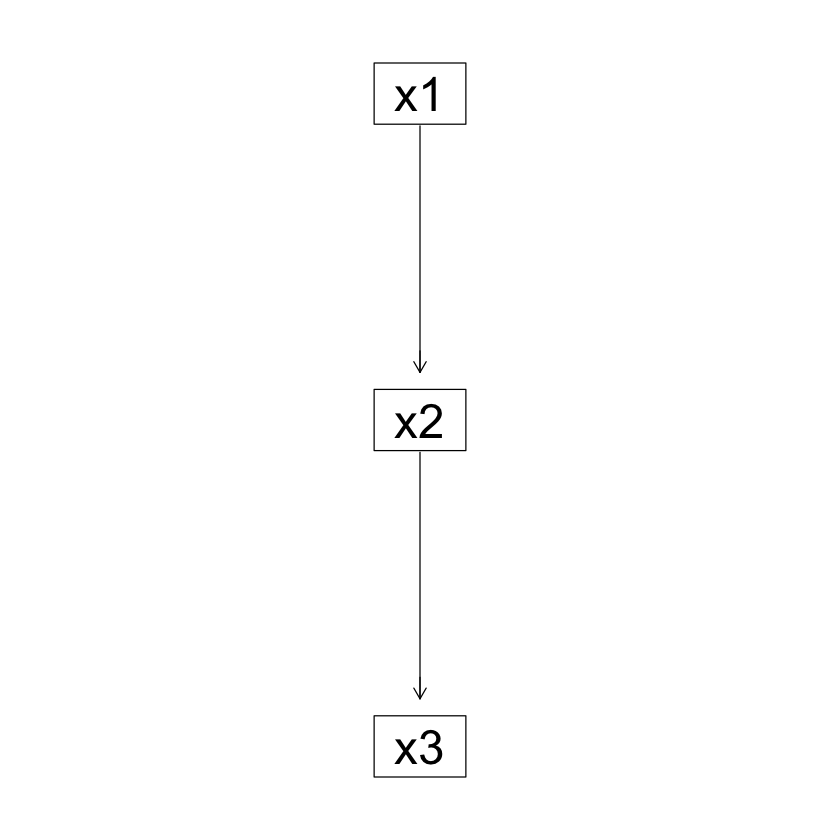

In [8]:
result <- k2(2, dummy, ordering = node_order )
result$dag
graphviz.plot(result$dag)

### Test: Asia Dataset

In [9]:
asia <- read_csv('https://www.ccd.pitt.edu/wiki/images/ASIA10k.csv')
head(asia)

Rows: 10000 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): asia, tub, smoke, lung, bronc, either, xray, dysp

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


asia,tub,smoke,lung,bronc,either,xray,dysp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,no,no,no,no,no,no,yes
no,no,yes,no,no,no,no,no
no,no,no,no,no,no,no,no
no,no,yes,no,no,no,no,no
no,no,yes,no,yes,no,no,yes
no,no,yes,no,no,no,no,no


PHASE 1: Building Undirected Network...
Calculating Mutual Information...
Building initial network...
PHASE 2: Achieving Complete Connectivity...
Achieving complete connectivity...


Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."


PHASE 3: Refining Graph Structure...
Found 0 triangles to refine...
PHASE 4-7: Assigning Orientations...
PHASE 4: Conditional independence tests...
Completing orientations...
Extracting topological order...



  Random/Generated Bayesian network

  model:
   [asia][smoke][tub][lung|smoke][bronc|smoke][either|tub:lung]
   [dysp|bronc:either][xray|either]
  nodes:                                 8 
  arcs:                                  7 
    undirected arcs:                     0 
    directed arcs:                       7 
  average markov blanket size:           2.25 
  average neighbourhood size:            1.75 
  average branching factor:              0.88 

  generation algorithm:                  Empty 


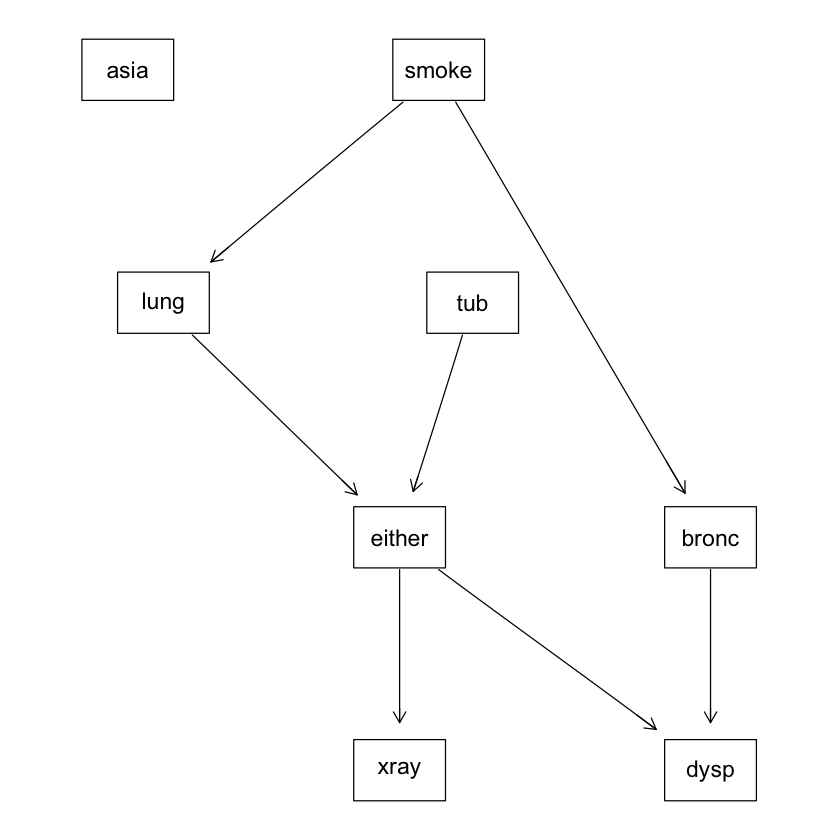

In [10]:
asia_order <- get_node_ordering_for_K2(asia, alpha = 0.9)
asia_net <- k2(ncol(asia) - 1, asia, asia_order)
asia_net$dag
graphviz.plot(asia_net$dag)

In [11]:
sachs <- read_csv('https://www.ccd.pitt.edu/wiki/images/SACHS10k.csv')
sachs <- sachs |> select(PKC, Plcg, PKA, PIP3, Raf, Jnk, P38, PIP2, Mek, Erk, Akt)

head(sachs)

Rows: 10000 Columns: 11
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (11): Akt, Erk, Jnk, Mek, P38, PIP2, PIP3, PKA, PKC, Plcg, Raf

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


PKC,Plcg,PKA,PIP3,Raf,Jnk,P38,PIP2,Mek,Erk,Akt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,2,2,1,1,1,1,1,1,1
2,1,2,2,1,1,2,1,1,2,1
1,3,1,2,3,3,3,2,1,1,1
1,1,3,3,2,1,1,1,1,2,1
2,2,2,3,1,1,1,1,1,2,1
2,1,2,1,2,2,1,1,2,2,1


PHASE 1: Building Undirected Network...
Calculating Mutual Information...
Building initial network...
PHASE 2: Achieving Complete Connectivity...
Achieving complete connectivity...


Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."
Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."


PHASE 3: Refining Graph Structure...
Found 0 triangles to refine...
PHASE 4-7: Assigning Orientations...
PHASE 4: Conditional independence tests...
Completing orientations...
Extracting topological order...



  Random/Generated Bayesian network

  model:
   [PKC][Plcg][Raf|PKC][PIP3|Plcg][Erk|PKC:Raf][PIP2|Plcg:PIP3][PKA|PKC:Raf:Erk]
   [Jnk|PKC:PKA][P38|PKC:PKA][Mek|PKC:Raf:Erk:PKA][Akt|Erk:PKA]
  nodes:                                 11 
  arcs:                                  19 
    undirected arcs:                     0 
    directed arcs:                       19 
  average markov blanket size:           3.45 
  average neighbourhood size:            3.45 
  average branching factor:              1.73 

  generation algorithm:                  Empty 


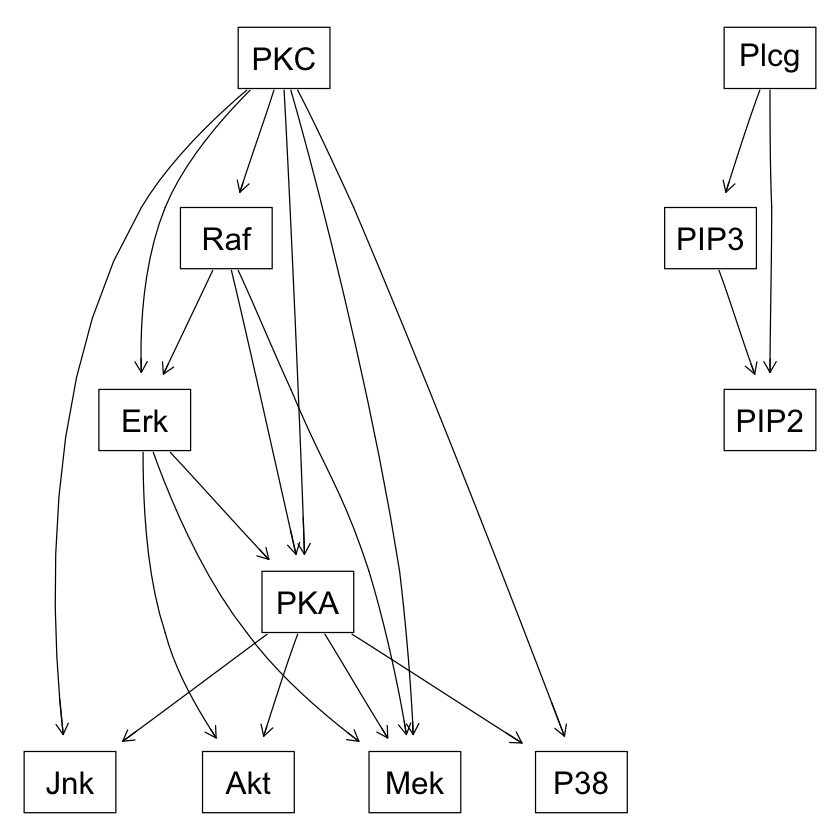

In [12]:
sachs_order <- get_node_ordering_for_K2(sachs, alpha = 0.9)
sachs_net <- k2(ncol(sachs) - 1, sachs, sachs_order)
sachs_net$dag
graphviz.plot(sachs_net$dag)

In [ ]:
child <- read_csv('https://www.ccd.pitt.edu/wiki/images/CHILD10k.csv')
child <- child |> select(BirthAsphyxia, Disease, Sick, DuctFlow, CardiacMixing, LungParench, LungFlow, LVH, Age, Grunting, HypDistrib, HypoxiaInO2, CO2, ChestXray, LVHreport, GruntingReport, LowerBodyO2, RUQO2, CO2Report, XrayReport)

head(child)

Rows: 10000 Columns: 20
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (20): BirthAsphyxia, HypDistrib, HypoxiaInO2, CO2, ChestXray, Grunting, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


BirthAsphyxia,Disease,Sick,DuctFlow,CardiacMixing,LungParench,LungFlow,LVH,Age,Grunting,HypDistrib,HypoxiaInO2,CO2,ChestXray,LVHreport,GruntingReport,LowerBodyO2,RUQO2,CO2Report,XrayReport
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,PAIVS,yes,Lt_to_Rt,Complete,Normal,Low,no,0-3_days,no,Equal,Moderate,Normal,Oligaemic,no,no,5-12,5-12,>=7.5,Grd_Glass
no,TGA,yes,None,Transp.,Abnormal,Low,no,0-3_days,yes,Equal,Severe,Normal,Asy/Patch,no,no,12+,<5,<7.5,Asy/Patchy
no,TGA,yes,None,Transp.,Normal,High,yes,0-3_days,no,Equal,Severe,Normal,Normal,yes,no,12+,5-12,<7.5,Normal
no,Lung,yes,None,Mild,Abnormal,Normal,no,0-3_days,yes,Equal,Moderate,Normal,Asy/Patch,no,yes,5-12,5-12,>=7.5,Asy/Patchy
no,Fallot,no,Lt_to_Rt,Complete,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Normal,no,no,5-12,5-12,<7.5,Normal
no,Fallot,no,Lt_to_Rt,Mild,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Oligaemic,no,yes,5-12,<5,<7.5,Oligaemic


PHASE 1: Building Undirected Network...
Calculating Mutual Information...
Building initial network...
PHASE 2: Achieving Complete Connectivity...
Achieving complete connectivity...


Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."
Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."
Warning message in shortest_paths(g, from = from, to = to):
"At vendor/cigraph/src/paths/unweighted.c:444 : Couldn't reach some vertices."


PHASE 3: Refining Graph Structure...
Found 0 triangles to refine...
PHASE 4-7: Assigning Orientations...
PHASE 4: Conditional independence tests...
Completing orientations...
Extracting topological order...



  Random/Generated Bayesian network

  model:
   [BirthAsphyxia][LungParench][Disease|BirthAsphyxia:LungParench]
   [Grunting|LungParench][CO2|LungParench][Sick|LungParench:Disease:Grunting]
   [DuctFlow|Disease][CardiacMixing|Disease][LungFlow|Disease][LVH|Disease]
   [GruntingReport|Grunting][CO2Report|CO2][Age|Disease:Sick]
   [HypDistrib|DuctFlow:CardiacMixing][HypoxiaInO2|LungParench:CardiacMixing]
   [ChestXray|LungParench:LungFlow][LVHreport|LVH]
   [LowerBodyO2|HypDistrib:HypoxiaInO2][RUQO2|HypoxiaInO2][XrayReport|ChestXray]
  nodes:                                 20 
  arcs:                                  26 
    undirected arcs:                     0 
    directed arcs:                       26 
  average markov blanket size:           3.20 
  average neighbourhood size:            2.60 
  average branching factor:              1.30 

  generation algorithm:                  Empty 


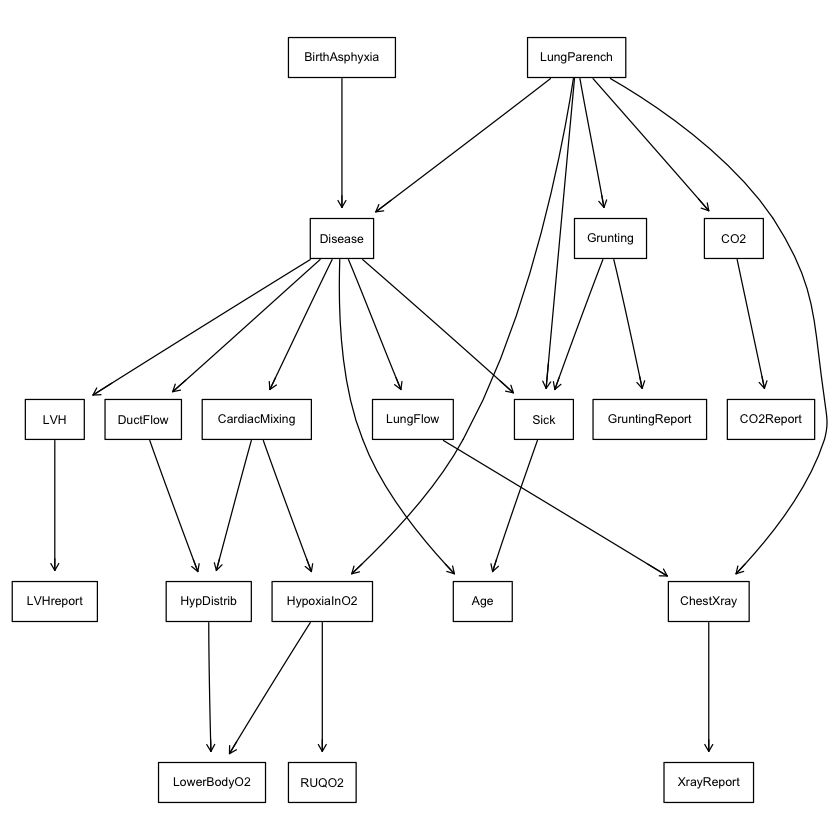

In [14]:
child_order <- get_node_ordering_for_K2(child, alpha = 0.9)
child_net <- k2(ncol(child) - 1, child, child_order)
child_net$dag
graphviz.plot(child_net$dag)